In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
from sklearn.metrics import ndcg_score, dcg_score
from sklearn.ensemble import RandomForestRegressor

In [35]:
df = pd.read_csv('intern_task.csv')
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,2,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001350,0.000002,3.0,1.500000
235254,2,29995,1.0,0.0,1.0,0.0,1.0,0.500000,0.0,0.500000,...,0.0,0.000000,0.000000,0.471409,39.908056,0.000000,0.004850,0.000014,9.0,4.500000
235255,1,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001064,0.000001,1.0,0.500000
235256,2,29995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


**Займемся предобработкой данных**. Проверим датасет на пропуски и наличие категориальных значений

In [36]:
df.isna().any().any() # нет пропусков в данных

False

In [37]:
df.select_dtypes('object').empty # нет категориальных значений

True

**Посмотрим на основные характеристики признаков и целевой переменной**

In [38]:
df.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


Признаков много и визуальный анализ не принесет своих результатов. Построим график, посмотрим на распределение рангов внутри query_id

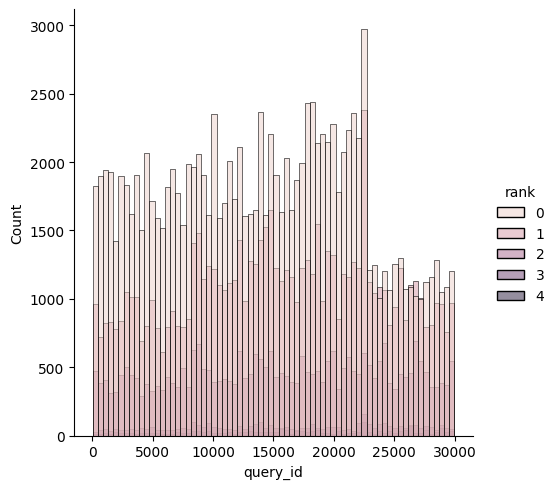

In [33]:
sns.displot(df, x="query_id", hue="rank")
plt.show()

Посмотрим на матрицу корреляций числовых признаков с целевой переменной. Признаков очень много, поэтому из анализа можно вынести то, что какие-то признаки сильно влияют на ранг, другие - слабо. Одни повышают оценку, другие - понижают

In [6]:
df.corr(numeric_only=True)

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
rank,1.000000,0.074057,-0.034239,0.097110,0.177743,0.120893,-0.029628,0.078850,0.109373,0.231477,...,-0.002400,-0.000130,0.135449,0.098959,0.121585,0.149626,0.155181,0.001207,0.017734,0.087033
query_id,0.074057,1.000000,-0.040320,-0.019186,-0.004201,0.020878,-0.036808,-0.005223,-0.007782,0.032868,...,-0.005803,0.001679,0.026565,0.000980,0.006226,0.049949,0.034563,-0.005864,0.001791,0.011541
feature_0,-0.034239,-0.040320,1.000000,0.131044,0.560199,0.155114,0.979494,0.590972,0.008262,0.176838,...,-0.020799,0.000721,0.083786,0.437207,0.335744,-0.111323,-0.047251,0.026149,0.309202,0.162987
feature_1,0.097110,-0.019186,0.131044,1.000000,0.208730,0.196483,0.142909,0.119076,0.890659,0.159313,...,-0.007154,-0.001405,0.178257,0.105447,0.134541,0.134350,0.105877,0.016457,0.114352,0.182067
feature_2,0.177743,-0.004201,0.560199,0.208730,1.000000,0.306295,0.538310,0.482131,0.124211,0.768004,...,-0.020478,0.000422,0.240712,0.435177,0.621490,0.111337,0.189865,0.037717,0.235129,0.224031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_139,0.149626,0.049949,-0.111323,0.134350,0.111337,0.833796,-0.067245,0.139908,0.195519,0.287774,...,-0.009599,-0.000954,0.843068,0.179221,0.098203,1.000000,0.336723,0.006884,0.020168,0.145930
feature_140,0.155181,0.034563,-0.047251,0.105877,0.189865,0.225540,-0.013788,0.191179,0.149277,0.355177,...,-0.010228,0.000567,0.285388,0.216457,0.189261,0.336723,1.000000,0.169442,0.092988,0.262832
feature_141,0.001207,-0.005864,0.026149,0.016457,0.037717,0.036037,0.029016,-0.003988,0.003916,0.007805,...,-0.002304,-0.000052,0.037421,-0.020480,0.044194,0.006884,0.169442,1.000000,0.072902,0.097090
feature_142,0.017734,0.001791,0.309202,0.114352,0.235129,0.084797,0.305479,0.143931,0.076314,0.095519,...,-0.006998,-0.000398,0.075562,0.086268,0.307781,0.020168,0.092988,0.072902,1.000000,0.570354


Отделим признаки от целевой переменной

In [39]:
X = df.drop(columns=['rank'], axis=1)
y = df['rank']
X.head()

,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,0.000000,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.004251,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,0.008501,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.012752,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,0.017003,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


Разделим данные на тренировочную и тестовую части, размер тестовой части сделаем 30% от всех данных. Фиксируем random state для воспроизводимости результатов

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

Заметим, что ранг в данных является числом, что может натолкнуть на мысль об использовании линейной регрессии для предсказаний. По моей гипотезе это вряд ли сработает - никто не гарантирует линейную связь признаков и переменной, а значит, эта довольно простая архитектура модели вряд ли выбьет хорошее качество на тесте. Проверим это

In [42]:
model = LinearRegression()
model.fit(X_train, y_train);

Оценим метрики: ndcg_5, отражающую качество ранжирования. Она изменяется от 0 до 1, где 1 достигают лучшие модели, а 0 - худшие и dcg

In [57]:
ndcg_5 = ndcg_score(np.array([y_test]), np.array([model.predict(X_test)]), k=5)
dcg = dcg_score(np.array([y_test]), np.array([model.predict(X_test)]), k=5)

In [58]:
ndcg_5

0.25437015395521206

In [59]:
dcg

3.0

Как и ожидалось, результаты достаточно грустные. Попробуем использовать случайный лес

In [22]:
model3 = RandomForestRegressor()
model3.fit(X_train, y_train)

RandomForestRegressor()

In [54]:
ndcg_5 = ndcg_score(np.array([y_test]), np.array([model3.predict(X_test)]), k=5)
dcg = dcg_score(np.array([y_test]), np.array([model3.predict(X_test)]), k=5)

In [24]:
ndcg_5

0.9999999999999999

In [55]:
dcg

11.793836475517567

Мы получили шикарный результат, почти достигнув единицы, но какой ценой? Случайный лес очень долго обучается и в случае с большим объемом данных вряд ли будет полезен (задача отпадет быстрее чем ее решит случайный лес)

Время доставать козырь из рукава - градиентный бустинг

In [45]:
xgb1 = xgb.XGBRegressor() # инициализация xgboost
xgb1.fit(X_train, y_train); # обучаем на обучающей выборке

In [49]:
ndcg_5 = ndcg_score(np.array([y_test]), np.array([xgb1.predict(X_test)]), k=5)
dcg = dcg_score(np.array([y_test]), np.array([xgb1.predict(X_test)]), k=5)

In [47]:
ndcg_5

0.9999999999999999

In [50]:
dcg

11.793836475517567

Получили такое же завидное качество, но время обучения сократилось в десятки раз. Итого для данной задачи будем использовать градиентный бустинг